In [563]:
# import gurobipy as gp
# from gurobipy import GRB
# import logging

# logger = logging.getLogger('logger')
# logger.setLevel(logging.INFO)


# def calculate_revenue(da_price, ss_price, energy, energy_label, bid=None):

#     # Calculate price difference
#     price_diff = da_price - ss_price

#     if bid != None:
#         # Calculate revenue with a given bid (no optimization)
#         revenue = ss_price * energy_label + price_diff * bid - 0.07 * (energy_label - bid) * (energy_label - bid)

#         return bid, revenue

#     elif bid == None:
#         # Create Gurobi model
#         model = gp.Model("OptimalBid")

#         # Add bid variable to optimize
#         bid = model.addVar(name="bid")

#         # Define valid boundaries
#         lb_constraint = model.addConstr(bid >= 0, name="lower_bound")
#         ub_constraint = model.addConstr(bid <= 1800, name="upper_bound")

#         # Define revenue function
#         revenue_obj = ss_price * energy + price_diff * bid - 0.07 * (energy - bid) * (energy - bid)

#         # Set objective to maximize revenue function
#         model.setObjective(revenue_obj, GRB.MAXIMIZE)

#         # Add the KKT condition as a constraint (Gradient must be 0)
#         model.addConstr(price_diff + 0.14 * (energy - bid) == 0, "KKT")

#         # Optimize model
#         model.optimize()

#         # Check if optimal solution was found
#         if model.status == GRB.OPTIMAL:
            
#             # Manual case distinction
#             if lb_constraint.Pi == 0 and ub_constraint.Pi == 0:
#                 optimal_bid = energy + 7.14 * price_diff
#                 # Adjust solution if it's outside the valid boundaries
#                 optimal_bid = min(max(optimal_bid, 0), 1800)

#             elif lb_constraint.Pi != 0 and ub_constraint.Pi == 0:
#                 optimal_bid = 0

#             elif lb_constraint.Pi == 0 and ub_constraint.Pi != 0:
#                 optimal_bid = 1800

#         else:
#             optimal_bid = energy + 7.14 * price_diff
#             optimal_bid = min(max(optimal_bid, 0), 1800)
#             #optimal_bid = energy

#         # Calculate revenue that would have been generated under real conditions
#         bid = optimal_bid
#         revenue = ss_price * energy_label + price_diff * optimal_bid - 0.07 * (energy_label - optimal_bid)**2

#         return bid, revenue


In [564]:
import logging

logger = logging.getLogger('logger')
logger.setLevel(logging.INFO)

### Function to calculate generated revenue for a given bid

In [565]:
def calculate_revenue(da_price_label, ss_price_label, energy_label, price_diff_pred=None, energy_pred=None, bid=None, best_possible=False):
    """Calculates the revenue that would have been generated for a given bid"""
    
    # Calculate price difference between DA-price and SS-price
    
    price_diff_label = da_price_label - ss_price_label

    if bid != None:
        # Calculate revenue that would have been generated for a given bid (no optimization)
        revenue = ss_price_label * energy_label + price_diff_label * bid - 0.07 * (energy_label - bid)**2
        return bid, revenue

    elif bid == None:
        # Calculate optimal bidding value decision
        if best_possible:
            optimal_bid = energy_label + 7.14 * price_diff_label
        else:
            optimal_bid = energy_pred + 7.14 * price_diff_pred
        # Keep the calculated bid within the valid boundaries
        optimal_bid = min(max(optimal_bid, 0), 1800)
        # Calculate revenue that would have been generated for the optimized bid
        revenue = ss_price_label * energy_label + price_diff_label * optimal_bid - 0.07 * (energy_label - optimal_bid)**2

        return optimal_bid, revenue


### Function to optimize Bidding Value

In [566]:
def optimize_bid(da_price, ss_price, energy):
    """Optimizes the bidding value decision depending on the forecast results of energy production, Day-Ahead price and Single-System Price"""
    
    # Calculate price difference between DA-price and SS-price
    price_diff = da_price - ss_price
    # Calculate optimal bidding value decision
    optimal_bid = energy + 7.14 * price_diff
    # Keep the calculated bid within the valid boundaries
    optimal_bid = min(max(optimal_bid, 0), 1800)
    
    return optimal_bid

### Merging Energy Forecasts with Labels

In [567]:
from model_utils import *
from Preprocessing import FeatureEngineerer
import numpy as np

merged_hornsea = pd.read_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("preprocessed_pes_with_energy.parquet")

feature_engineerer_wind = FeatureEngineerer(label = 'Wind_MWh_credit', columns_to_ohe=['unavailabilityType', 'affectedUnit'])
feature_engineerer_wind.perform_feature_engineering(merged_hornsea, deployment = False)

feature_engineerer_solar = FeatureEngineerer(label = "Solar_MWh_credit", columns_to_ohe=[])
feature_engineerer_solar.perform_feature_engineering(merged_pes, deployment = False)

wind_model = LGBMRegressorModel(feature_engineerer_wind, quantiles=np.round(np.arange(0.1, 1.0, 0.1), 1), model_save_dir="lgbm_model_wind", load_pretrained=True)
solar_model = LGBMRegressorModel(feature_engineerer_solar, quantiles=np.round(np.arange(0.1, 1.0, 0.1), 1), model_save_dir="lgbm_model_solar", load_pretrained=True)

Loaded pretrained Quantile Regressor model for quantile 0.1 from lgbm_model_wind\lgbm_model_quantile_0.1.pkl
Loaded pretrained Quantile Regressor model for quantile 0.2 from lgbm_model_wind\lgbm_model_quantile_0.2.pkl
Loaded pretrained Quantile Regressor model for quantile 0.3 from lgbm_model_wind\lgbm_model_quantile_0.3.pkl
Loaded pretrained Quantile Regressor model for quantile 0.4 from lgbm_model_wind\lgbm_model_quantile_0.4.pkl
Loaded pretrained Quantile Regressor model for quantile 0.5 from lgbm_model_wind\lgbm_model_quantile_0.5.pkl
Loaded pretrained Quantile Regressor model for quantile 0.6 from lgbm_model_wind\lgbm_model_quantile_0.6.pkl
Loaded pretrained Quantile Regressor model for quantile 0.7 from lgbm_model_wind\lgbm_model_quantile_0.7.pkl
Loaded pretrained Quantile Regressor model for quantile 0.8 from lgbm_model_wind\lgbm_model_quantile_0.8.pkl
Loaded pretrained Quantile Regressor model for quantile 0.9 from lgbm_model_wind\lgbm_model_quantile_0.9.pkl
Loaded pretrained Q

In [568]:
df_energy = pd.read_csv("data/Energy_Data_20200920_20240118.csv")
df_energy["dtm"] = pd.to_datetime(df_energy["dtm"])

df_pred_wind = pd.concat([pd.DataFrame(wind_model.predict(feature_engineerer_wind.X_test)), feature_engineerer_wind.y_test.reset_index()], axis=1)
df_pred_solar = pd.concat([pd.DataFrame(solar_model.predict(feature_engineerer_solar.X_test)), feature_engineerer_solar.y_test.reset_index()], axis=1)

df_pred = pd.merge(df_pred_wind, df_pred_solar, on="dtm", how="inner", suffixes=("_wind", "_solar"))

for column in ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9']:
    df_pred[column] = df_pred[f"{column}_wind"] + df_pred[f"{column}_solar"]
df_pred = df_pred.drop(['0.1_wind', '0.2_wind', '0.3_wind', '0.4_wind', '0.5_wind', '0.6_wind',
                        '0.7_wind', '0.8_wind', '0.9_wind', '0.1_solar', '0.2_solar', '0.3_solar', '0.4_solar', '0.5_solar',
                        '0.6_solar', '0.7_solar', '0.8_solar', '0.9_solar'], axis=1)

df_pred["energy_label"] = df_pred["Wind_MWh_credit"] + df_pred["Solar_MWh_credit"]
df_pred = df_pred.drop(["Wind_MWh_credit", "Solar_MWh_credit"], axis=1)

df_final = df_pred.merge(df_energy, on="dtm", how="left")
df_final = df_final.drop(["MIP", "Solar_MW", "Solar_capacity_mwp", "Solar_installedcapacity_mwp", "Wind_MW", "boa_MWh"], axis=1)
df_final

,dtm,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,energy_label,SS_Price,DA_Price
0,2023-07-01 00:00:00+00:00,388.819278,442.067640,484.006924,489.658750,522.568531,530.651199,531.633583,550.929247,556.602185,518.961,10.00000,54.04
1,2023-07-01 00:30:00+00:00,388.819278,442.067640,480.363620,485.470796,515.140862,519.624711,532.899235,545.162069,556.504415,508.881,-6.91000,54.04
2,2023-07-01 01:00:00+00:00,388.819278,442.067640,477.719233,482.681673,515.817850,523.075215,530.690094,539.724339,553.646364,464.601,-27.91067,43.57
3,2023-07-01 01:30:00+00:00,385.654623,442.067640,478.903546,483.664597,515.817850,523.615152,526.060690,539.950913,549.305605,459.261,-26.00000,43.57
4,2023-07-01 02:00:00+00:00,386.336574,442.067640,482.146488,486.702289,523.245519,523.800852,537.760518,543.752875,549.305605,478.631,-24.00000,39.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8827,2023-12-31 21:30:00+00:00,537.548958,545.268988,547.483888,562.416320,563.668455,572.886838,581.767946,586.045114,589.498367,566.130,47.94000,44.24
8828,2023-12-31 22:00:00+00:00,537.548958,545.268988,547.483888,562.867953,563.792455,572.886838,584.292179,585.674916,587.197356,560.100,58.39000,41.38
8829,2023-12-31 22:30:00+00:00,537.548958,545.540730,547.483888,562.655650,563.826945,576.229375,584.130101,585.823144,587.270879,572.640,8.72000,41.38
8830,2023-12-31 23:00:00+00:00,537.548958,546.858597,547.269829,563.221939,563.826945,576.229375,584.279232,585.823144,588.237390,586.320,5.00000,47.80


In [569]:
import joblib

lr_price_model = joblib.load('price_models/linear_regression_model.pkl')
rfr_price_model = joblib.load('price_models/random_forest_model.pkl')
gbr_price_model = joblib.load('price_models/gradient_boosting_model.pkl')
lgbm_price_model = joblib.load('price_models/lgbm_model.pkl')

X_test_price = joblib.load('price_data/X_test.pkl')
y_test_price = joblib.load('price_data/y_test.pkl')

In [570]:
lr_price_model.predict(X_test_price)

array([[-23.69278117],
       [-23.69278117],
       [-18.58934888],
       ...,
       [  2.46965293],
       [  8.1582768 ],
       [ -3.02508562]])

In [571]:
rfr_price_model.predict(X_test_price)

array([16.93995541, 16.93995541, 16.53935459, ..., -3.22530091,
       -3.22530091, -3.22530091])

In [572]:
gbr_price_model.predict(X_test_price)

array([-19.35900321, -19.35900321, -16.97865451, ...,   5.94417278,
        -1.06813414,   1.05754426])

In [587]:
lgbm_price_model.predict(X_test_price)["0.2"]

array([0., 0., 0., ..., 0., 0., 0.])

In [574]:
rfr_pred = pd.DataFrame(rfr_price_model.predict(X_test_price), columns=["price_diff_rfr"])
rfr_pred = pd.concat([rfr_pred, y_test_price.reset_index()["dtm"]], axis=1)
rfr_pred = rfr_pred.drop_duplicates()
df_final = pd.merge(df_final, rfr_pred, on="dtm", how="left").drop_duplicates()

In [575]:
gbr_pred = pd.DataFrame(gbr_price_model.predict(X_test_price), columns=["price_diff_gbr"])
gbr_pred = pd.concat([gbr_pred, y_test_price.reset_index()["dtm"]], axis=1)
gbr_pred = gbr_pred.drop_duplicates()
df_final = pd.merge(df_final, gbr_pred, on="dtm", how="left").drop_duplicates()

In [576]:
lgbm_pred = pd.DataFrame(lgbm_price_model.predict(X_test_price)["0.4"], columns=["price_diff_lgbm"])
lgbm_pred = pd.concat([lgbm_pred, y_test_price.reset_index()["dtm"]], axis=1)
lgbm_pred = lgbm_pred.drop_duplicates()
df_final = pd.merge(df_final, lgbm_pred, on="dtm", how="left").drop_duplicates()

In [577]:
lr_pred = pd.DataFrame(lr_price_model.predict(X_test_price), columns=["price_diff_lr"])
lr_pred = pd.concat([lr_pred, y_test_price.reset_index()["dtm"]], axis=1)
lr_pred = lr_pred.drop_duplicates()
df_final = pd.merge(df_final, lr_pred, on="dtm", how="left").drop_duplicates()

### Calculating revenues for different Bidding Strategies

In [578]:
df_final["revenue_05_bid"] = df_final.apply(lambda row: calculate_revenue(da_price_label=row["DA_Price"], 
                                                                           ss_price_label=row["SS_Price"],
                                                                           energy_label=row["energy_label"],
                                                                           bid=row[f"0.5"])[1],
                                                                           axis=1)

df_final["revenue_best_possible_bid"] = df_final.apply(lambda row: calculate_revenue(da_price_label=row["DA_Price"], 
                                                                                     ss_price_label=row["SS_Price"], 
                                                                                     energy_label=row["energy_label"],
                                                                                     best_possible=True)[1],
                                                                                     axis=1)

df_final["revenue_optimized_bid_lr"] = df_final.apply(lambda row: calculate_revenue(da_price_label=row["DA_Price"], 
                                                                                 ss_price_label=row["SS_Price"],  
                                                                                 energy_label=row["energy_label"],
                                                                                 price_diff_pred=row["price_diff_lr"],
                                                                                 energy_pred=row["0.5"])[1], 
                                                                                 axis=1)

df_final["revenue_optimized_bid_gbr"] = df_final.apply(lambda row: calculate_revenue(da_price_label=row["DA_Price"], 
                                                                                 ss_price_label=row["SS_Price"],  
                                                                                 energy_label=row["energy_label"],
                                                                                 price_diff_pred=row["price_diff_gbr"],
                                                                                 energy_pred=row["0.5"])[1], 
                                                                                 axis=1)

df_final["revenue_optimized_bid_lgbm"] = df_final.apply(lambda row: calculate_revenue(da_price_label=row["DA_Price"], 
                                                                                 ss_price_label=row["SS_Price"],  
                                                                                 energy_label=row["energy_label"],
                                                                                 price_diff_pred=row["price_diff_lgbm"],
                                                                                 energy_pred=row["0.5"])[1], 
                                                                                 axis=1)

df_final["revenue_optimized_bid_rfr"] = df_final.apply(lambda row: calculate_revenue(da_price_label=row["DA_Price"], 
                                                                                 ss_price_label=row["SS_Price"],  
                                                                                 energy_label=row["energy_label"],
                                                                                 price_diff_pred=row["price_diff_rfr"],
                                                                                 energy_pred=row["0.5"])[1], 
                                                                                 axis=1)


# df_final_reduced_1 = df_final.copy()[:200]
# df_final_reduced_2 = df_final.copy()[4000:4200]
# df_final_reduced_3 = df_final.copy()[8000:8200]

# for df in [df_final_reduced_1, df_final_reduced_2, df_final_reduced_3]:
#     df[f"revenue_05_bid"] = df.apply(lambda row: calculate_revenue(da_price=row["DA_Price"], 
#                                                                    ss_price=row["SS_Price"],
#                                                                    energy=row["energy_label"],
#                                                                    energy_label=row["energy_label"],
#                                                                    bid=row[f"0.5"])[1],
#                                                                    axis=1)


#     df['revenue_optimized_bid'] = df.apply(lambda row: calculate_revenue(da_price=row["DA_Price"], 
#                                                                          ss_price=row["SS_Price"], 
#                                                                          energy=row["0.5"], 
#                                                                          energy_label=row["energy_label"], 
#                                                                          bid=None)[1], 
#                                                                          axis=1)

#     df["revenue_best_possible_bid"] = df.apply(lambda row: calculate_revenue(da_price=row["DA_Price"], 
#                                                                          ss_price=row["SS_Price"], 
#                                                                          energy=row["energy_label"],
#                                                                          energy_label=row["energy_label"],
#                                                                          bid=None)[1], 
#                                                                          axis=1)


In [579]:
df_final["revenue_best_possible_bid"].mean()

35938.67739267378

In [580]:
df_final["revenue_optimized_bid_lr"].mean()

27702.611137532665

In [581]:
df_final["revenue_optimized_bid_rfr"].mean()

27044.310222184627

In [582]:
df_final["revenue_optimized_bid_gbr"].mean()

26123.611966738674

In [583]:
df_final["revenue_optimized_bid_lgbm"].mean()

28312.854466922327

In [584]:
df_final["revenue_05_bid"].mean()

28257.2917025513

In [10]:
revenue_optimized_bid = df_final['revenue_optimized_bid'].mean()
revenue_best_possible_bid = df_final['revenue_best_possible_bid'].mean()

print(f"Generated revenue for the optimized bid: {round(revenue_optimized_bid, 3)}")
print(f"Best possible revenue: {round(revenue_best_possible_bid, 3)}")
print(f"The best possible revenue is {round((revenue_best_possible_bid-revenue_optimized_bid)/(revenue_optimized_bid)*100, 3)}% larger than the revenue for the optimized bid")

Generated revenue for the optimized bid: 35298.619
Best possible revenue: 35930.278
The best possible revenue is 1.789% larger than the revenue for the optimized bid


### Plotting results

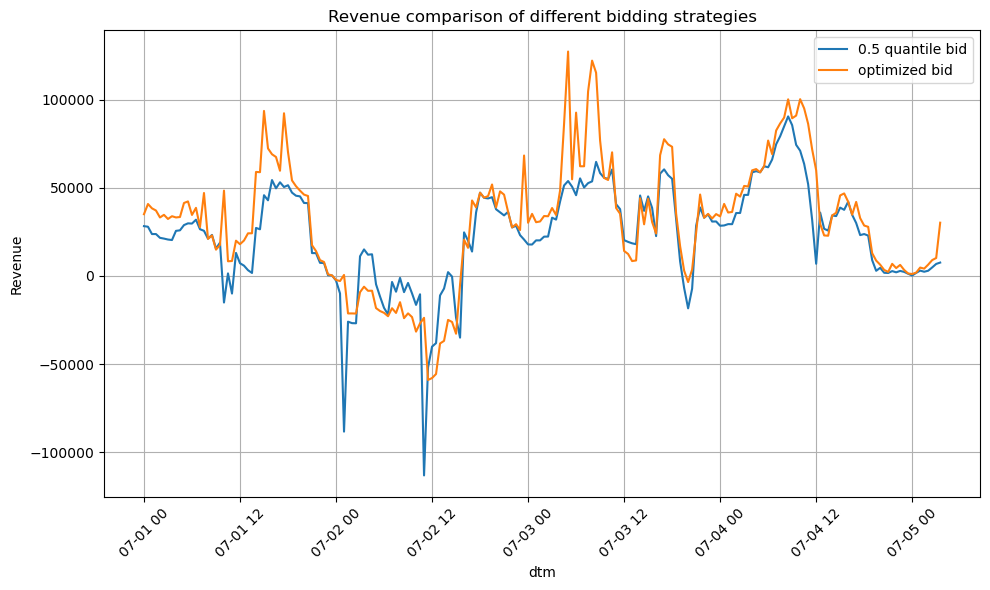

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(df_final_reduced_1['dtm'], df_final_reduced_1['revenue_05_bid'], label='0.5 quantile bid')
plt.plot(df_final_reduced_1['dtm'], df_final_reduced_1['revenue_optimized_bid'], label='optimized bid')
#plt.plot(df_final_reduced['dtm'], df_final_reduced['revenue_best_possible_bid'], label='Best possible revenue')

plt.title('Revenue comparison of different bidding strategies')
plt.xlabel('dtm')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
print(f"Revenue 0.5 quantile bid: {df_final_reduced_1['revenue_05_bid'].mean()}")
print(f"Revenue optimized_bid: {df_final_reduced_1['revenue_optimized_bid'].mean()}")
print(f"Revenue best possible bid: {df_final_reduced_1['revenue_best_possible_bid'].mean()}")

Revenue 0.5 quantile bid: 23245.72146789144
Revenue optimized_bid: 30802.4307009493
Revenue best possible bid: 35263.36281501289


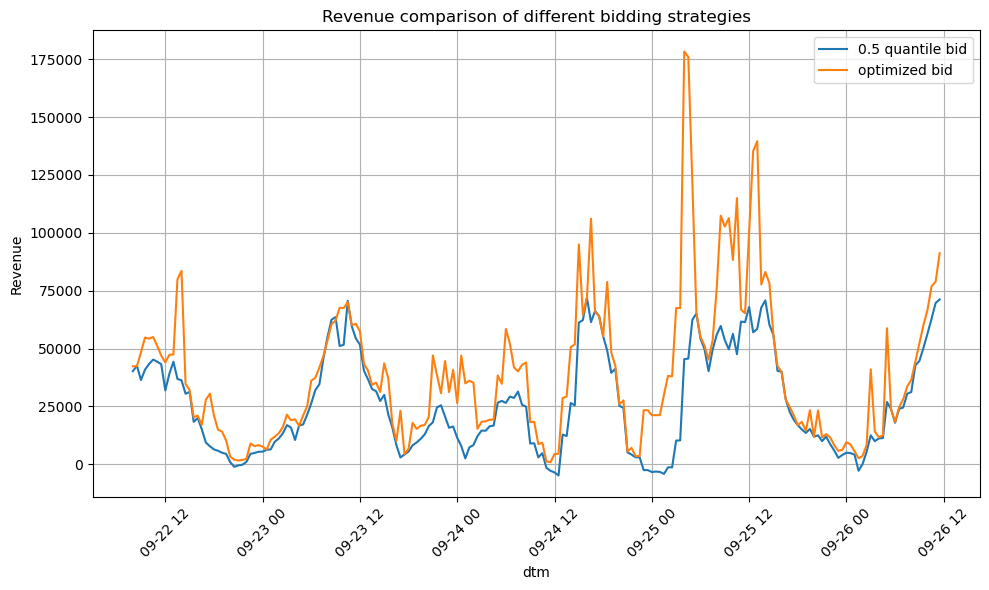

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(df_final_reduced_2['dtm'], df_final_reduced_2['revenue_05_bid'], label='0.5 quantile bid')
plt.plot(df_final_reduced_2['dtm'], df_final_reduced_2['revenue_optimized_bid'], label='optimized bid')
#plt.plot(df_final_reduced['dtm'], df_final_reduced['revenue_best_possible_bid'], label='Best possible revenue')

plt.title('Revenue comparison of different bidding strategies')
plt.xlabel('dtm')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
print(f"Revenue 0.5 quantile bid: {df_final_reduced_2['revenue_05_bid'].mean()}")
print(f"Revenue 0.5 optimized_bid: {df_final_reduced_2['revenue_optimized_bid'].mean()}")
print(f"Revenue best possible bid: {df_final_reduced_2['revenue_best_possible_bid'].mean()}")

Revenue 0.5 quantile bid: 26097.842586420913
Revenue 0.5 optimized_bid: 38927.08449180899
Revenue best possible bid: 39387.12324576339


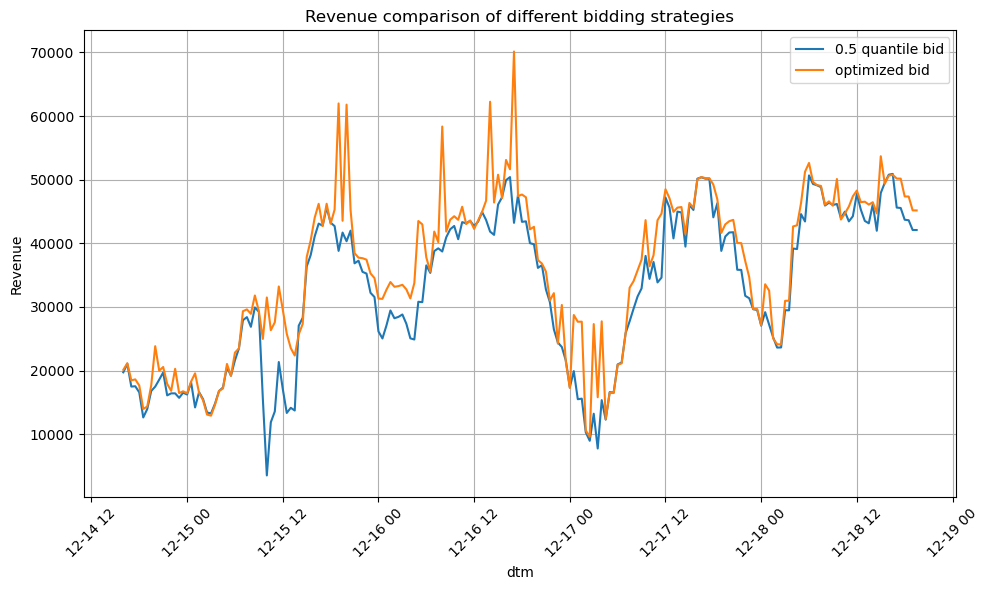

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(df_final_reduced_3['dtm'], df_final_reduced_3['revenue_05_bid'], label='0.5 quantile bid')
plt.plot(df_final_reduced_3['dtm'], df_final_reduced_3['revenue_optimized_bid'], label='optimized bid')
#plt.plot(df_final_reduced['dtm'], df_final_reduced['revenue_best_possible_bid'], label='Best possible revenue')

plt.title('Revenue comparison of different bidding strategies')
plt.xlabel('dtm')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
print(f"Revenue 0.5 quantile bid: {df_final_reduced_3['revenue_05_bid'].mean()}")
print(f"Revenue 0.5 optimized_bid: {df_final_reduced_3['revenue_optimized_bid'].mean()}")
print(f"Revenue best possible bid: {df_final_reduced_3['revenue_best_possible_bid'].mean()}")

Revenue 0.5 quantile bid: 32542.069104486938
Revenue 0.5 optimized_bid: 35920.00385160584
Revenue best possible bid: 36298.26824663991


In [17]:
mean_bid_revenues = {}
for quantile in range(1, 10):
    mean_bid_revenues[f"0.{quantile}"] = df_final.apply(lambda row: calculate_revenue(
                                                da_price=row["DA_Price"], 
                                                ss_price=row["SS_Price"],
                                                energy=row["energy_label"],
                                                energy_label=row["energy_label"],
                                                bid=row[f"0.{quantile}"])[1],
                                                axis=1).mean()

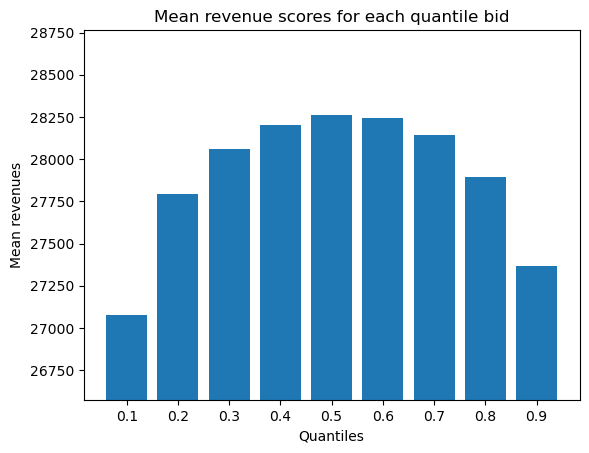

In [18]:
plt.bar(mean_bid_revenues.keys(), mean_bid_revenues.values())
plt.ylim(min(mean_bid_revenues.values()) - 500, max(mean_bid_revenues.values()) + 500)
plt.title("Mean revenue scores for each quantile bid")
plt.xlabel("Quantiles")
plt.ylabel("Mean revenues")

plt.show()


In [19]:
#TODO Testen mit Daniels Modell

In [20]:
# df_demand = pd.read_parquet("preprocessed_demand_with_energy.parquet")

# df_energy_2 = pd.read_csv("data\Energy_Data_20200920_20240118.csv")
# df_energy_3 = pd.read_csv("data\Energy_Data_20240119_20240519.csv")
# df_energy = pd.concat([df_energy_2, df_energy_3])

# df_energy = df_energy.rename(columns = {"timestamp_utc":"dtm"})
# df_energy["dtm"] = pd.to_datetime(df_energy["dtm"])
# df_energy = df_energy.sort_values("dtm")
# grouped_means = df_energy.groupby([df_energy.dtm.dt.year, df_energy.dtm.dt.month, df_energy.dtm.dt.hour]).transform('mean')
# df_energy = df_energy.fillna(grouped_means)
# df_energy = df_energy[["dtm", "SS_Price", "DA_Price"]]
# df_energy = df_energy.drop_duplicates()

# df_demand_energy = df_energy.merge(df_demand, on="dtm", how="left")

# columns_to_drop = ['Solar_MWh_credit', 'Wind_MWh_credit', 'affectedUnit', 'availableCapacity', 'hoursSinceOutage', 'hoursUntilOutageEnd', 'outage', 'unavailabilityType',
#        'unavailableCapacity']
# df_demand_energy = df_demand_energy.drop(columns_to_drop, axis=1)
# df_demand_energy = df_demand_energy.set_index("dtm")

In [21]:
# df_demand_energy.columns

In [22]:
# df_demand_energy = df_demand_energy[["SS_Price", "DA_Price", "temp", "total_prec", "wind_dir_cos", "wind_dir_sin", "wind_speed"]]

In [23]:
# from Preprocessing import FeatureEngineerer

# feature_engineerer_ss_price = FeatureEngineerer(label = 'SS_Price', scaler_name="standard")
# feature_engineerer_ss_price.perform_feature_engineering(df_demand_energy, deployment = False, labels_to_remove=["SS_Price", "DA_Price"])

# feature_engineerer_da_price = FeatureEngineerer(label = 'DA_Price')
# feature_engineerer_da_price.perform_feature_engineering(df_demand_energy, deployment = False, labels_to_remove=["SS_Price", "DA_Price"])

In [24]:
# feature_engineerer_da_price.X_train.shape

In [25]:
# X_train_ss = feature_engineerer_ss_price.X_train
# X_test_ss = feature_engineerer_ss_price.X_test
# X_val_ss = feature_engineerer_ss_price.X_val
# y_val_ss = feature_engineerer_ss_price.y_val
# y_train_ss = feature_engineerer_ss_price.y_train
# y_test_ss = feature_engineerer_ss_price.X_train

In [26]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset

# # Angepasste Architektur mit Dropout und Batch Normalization
# class ImprovedNN(nn.Module):
#     def __init__(self):
#         super(ImprovedNN, self).__init__()
#         self.fc1 = nn.Linear(54, 128)  # 54 Eingabefeatures -> 128 Neuronen im Hidden Layer
#         self.bn1 = nn.BatchNorm1d(128) # Batch Norm nach dem ersten Layer
#         self.fc2 = nn.Linear(128, 64)  # 128 Neuronen -> 64 Neuronen im Hidden Layer
#         self.bn2 = nn.BatchNorm1d(64)  # Batch Norm nach dem zweiten Layer
#         self.fc3 = nn.Linear(64, 1)    # 64 Neuronen -> 1 Ausgabe (für Regression)
#         self.relu = nn.ReLU()          # ReLU-Aktivierung
#         self.dropout = nn.Dropout(p=0.3)  # Dropout mit 30% Wahrscheinlichkeit

#     def forward(self, x):
#         x = self.relu(self.bn1(self.fc1(x)))
#         x = self.dropout(x)
#         x = self.relu(self.bn2(self.fc2(x)))
#         x = self.dropout(x)
#         x = self.fc3(x)
#         return x

# # Initialisiere das Modell, den Loss und den Optimizer
# model = ImprovedNN()
# criterion = nn.MSELoss()  # MSE Loss für Regression
# optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)  # Kleinere LR und L2 Regularisierung

# # Daten in Tensoren umwandeln
# X_train_tensor = torch.tensor(X_train_ss, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train_ss, dtype=torch.float32).view(-1, 1)
# X_val_tensor = torch.tensor(X_val_ss, dtype=torch.float32)
# y_val_tensor = torch.tensor(y_val_ss, dtype=torch.float32).view(-1, 1)
# X_test_tensor = torch.tensor(X_test_ss, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test_ss, dtype=torch.float32).view(-1, 1)

# # DataLoader erstellen
# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)  # Batch size auf 64 erhöht

# val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# # Trainingsfunktion mit Early Stopping
# def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=100, patience=10):
#     best_val_loss = float('inf')
#     patience_counter = 0
#     for epoch in range(epochs):
#         model.train()
#         running_loss = 0.0
#         for inputs, targets in train_loader:
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()

#         val_loss = 0.0
#         model.eval()
#         with torch.no_grad():
#             for inputs, targets in val_loader:
#                 outputs = model(inputs)
#                 loss = criterion(outputs, targets)
#                 val_loss += loss.item()

#         print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}')

#         # Early Stopping
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             patience_counter = 0  # Reset patience counter
#             best_model = model.state_dict()  # Speichere das beste Modell
#         else:
#             patience_counter += 1

#         if patience_counter >= patience:
#             print("Early stopping triggered")
#             model.load_state_dict(best_model)  # Lade das beste Modell
#             break

# # Trainiere das Modell
# train_model(model, criterion, optimizer, train_loader, val_loader, epochs=100)

# # Evaluation auf den Testdaten
# model.eval()
# with torch.no_grad():
#     test_outputs = model(X_test_tensor)
#     test_loss = criterion(test_outputs, y_test_tensor)
#     print(f'Test Loss: {test_loss.item()}')
